# Integrated Project 2

## Project Description

The data is stored in three files:
 - `'gold_recovery_train.csv'` — training dataset download
 - `'gold_recovery_test.csv'` — test dataset download
 - `'gold_recovery_full.csv'` — source dataset download
Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.
Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.
The source dataset contains the training and test sets with all the features.
You have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data. For that, use our instructions.


## Project instructions
1. Prepare the data
 - Open the files and look into the data.
        Path to files:
            /datasets/gold_recovery_train.csv
            /datasets/gold_recovery_test.csv
            /datasets/gold_recovery_full.csv
 - Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
 - Analyze the features not available in the test set. What are these parameters? What is their type?
 - Perform data preprocessing.
2. Analyze the data
 - Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
 - Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
 - Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.
3. Build the model
 - Write a function to calculate the final sMAPE value.
 - Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

## Data description
**Technological process**
 - Rougher feed — raw material
 - Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
     - Xanthate — promoter or flotation activator;
     - Sulphate — sodium sulphide for this particular process;
     - Depressant — sodium silicate.
 - Rougher process — flotation
 - Rougher tails — product residues
 - Float banks — flotation unit
 - Cleaner process — purification
 - Rougher Au — rougher gold concentrate
 - Final Au — final gold concentrate

**Parameters of stages**
 - air amount — volume of air
 - fluid levels
 - feed size — feed particle size
 - feed rate


## Feature naming
Here's how you name the features:

`'[stage].[parameter_type].[parameter_name]'`

Example: `'rougher.input.feed_ag'`

Possible values for `'[stage]'`:
 - rougher — flotation
 - primary_cleaner — primary purification
 - secondary_cleaner — secondary purification
 - final — final characteristics
 
Possible values for `'[parameter_type]'`:
 - input — raw material parameters
 - output — product parameters
 - state — parameters characterizing the current state of the stage
 - calculation — calculation characteristics


### Step 1 Prepare the data
 - Open the files and look into the data.
        Path to files:
            /datasets/gold_recovery_train.csv
            /datasets/gold_recovery_test.csv
            /datasets/gold_recovery_full.csv
 - Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
 - Analyze the features not available in the test set. What are these parameters? What is their type?
 - Perform data preprocessing.

In [76]:
# importing the necessary libraies

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import warnings
warnings.filterwarnings('ignore')

#### 1.1 Open the files and look into the data

In [2]:
# open the files and look into the data

df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
display(df_train.head())
display(df_test.head())
display(df_full.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
display(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


None

In [5]:
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

None

In [6]:
display(df_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


None

#### 1.2 Check that the recovery is calculated correctly. Using the training set, calculate recovery for the `'rougher.output.recovery'` features. Find the the MAE between your calculations and the features values.

In [7]:
def recovery(df, C, F, T):
    rec = 100 * ((df[C] * (df[F] - df[T])) / (df[F] * (df[C] - df[T])))
    return rec

In [8]:
vals_pred = recovery(df_train.dropna(subset=['rougher.output.recovery']), 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au')
vals_act = df_train['rougher.output.recovery'].dropna().to_list()

print(f"Mean Absolute Error: {mean_absolute_error(vals_act, vals_pred)}")

Mean Absolute Error: 9.303415616264301e-15


#### Summary

The mean absolute error is a very small number meaning the result is correct.

#### 1.4 Analyze the features not available in the test set.

In [9]:
df_types = df_full.dtypes.reset_index()
df_types.columns = ["name", "type"]
all_columns = pd.Series(list(set(df_full.columns).union(set(df_train.columns).union(set(df_test.columns)))))
df_temp = pd.DataFrame({"name": all_columns}).merge(df_types).sort_values(by="name")
df_temp["full"] = np.vectorize(lambda x: int(x in df_full.columns))(df_temp["name"].values)
df_temp["train"] = np.vectorize(lambda x: int(x in df_train.columns))(df_temp["name"].values)
df_temp["test"] = np.vectorize(lambda x: int(x in df_test.columns))(df_temp["name"].values)
df_temp[df_temp["test"]==0]

,name,type,full,train,test
83,final.output.concentrate_ag,float64,1,1,0
78,final.output.concentrate_au,float64,1,1,0
35,final.output.concentrate_pb,float64,1,1,0
64,final.output.concentrate_sol,float64,1,1,0
1,final.output.recovery,float64,1,1,0
33,final.output.tail_ag,float64,1,1,0
72,final.output.tail_au,float64,1,1,0
74,final.output.tail_pb,float64,1,1,0
48,final.output.tail_sol,float64,1,1,0
7,primary_cleaner.output.concentrate_ag,float64,1,1,0


#### Summary
Besides these all missing from the test set, these also do not include any of the `'state'` values. These are all outputs of the process and calculations based on those outputs. As they are only obtained later in the process, we can't use them as features in our models

#### 1.4 Perform data preprocessing

In [10]:
for df in [df_full, df_train, df_test]:
  if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)

In [11]:
print(df_train['final.output.recovery'].isna().sum())
print(df_train['rougher.output.recovery'].isna().sum())

1521
2573


In [12]:
df_test.merge(df_full[['final.output.recovery', 'rougher.output.recovery']], how='left', left_index=True, right_index=True).head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,68.910432,88.089657
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,68.143213,88.412756
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,67.776393,87.360133
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,61.467078,83.236367


In [13]:
df_test = df_test.merge(df_full[['final.output.recovery', 'rougher.output.recovery']], how='left', left_index=True, right_index=True)

In [14]:
df_train = df_train[~df_train['final.output.recovery'].isna()]
df_train = df_train[~df_train['rougher.output.recovery'].isna()]
df_train = df_train.fillna(method='ffill')

In [15]:
df_test = df_test[~df_test['final.output.recovery'].isna()]
df_test = df_test[~df_test['rougher.output.recovery'].isna()]
df_test = df_test.fillna(method='ffill')

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14149 non-null  float64
 1   final.output.concentrate_pb                         14149 non-null  float64
 2   final.output.concentrate_sol                        14149 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                     

### Step 2 Analyze the data
 - Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
 - Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
 - Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.


In [17]:
def display_group_density_plot(df, groupby, on, palette = None, figsize = None, title="", ax=None): 
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """
    if palette is None:
      palette = sns.color_palette('Set2')
    if figsize is None:
      figsize = (10, 5)

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    if ax is None:
      fig = plt.figure(figsize=figsize)
      ax = fig.add_subplot(111)
    
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value, ax=ax)
    if not title:
      title = str("Distribution of " + on + " per " + groupby + " group")
    
    ax.set_title(title,fontsize=16)
    ax.set_xlabel(on, fontsize=16)
    return ax 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


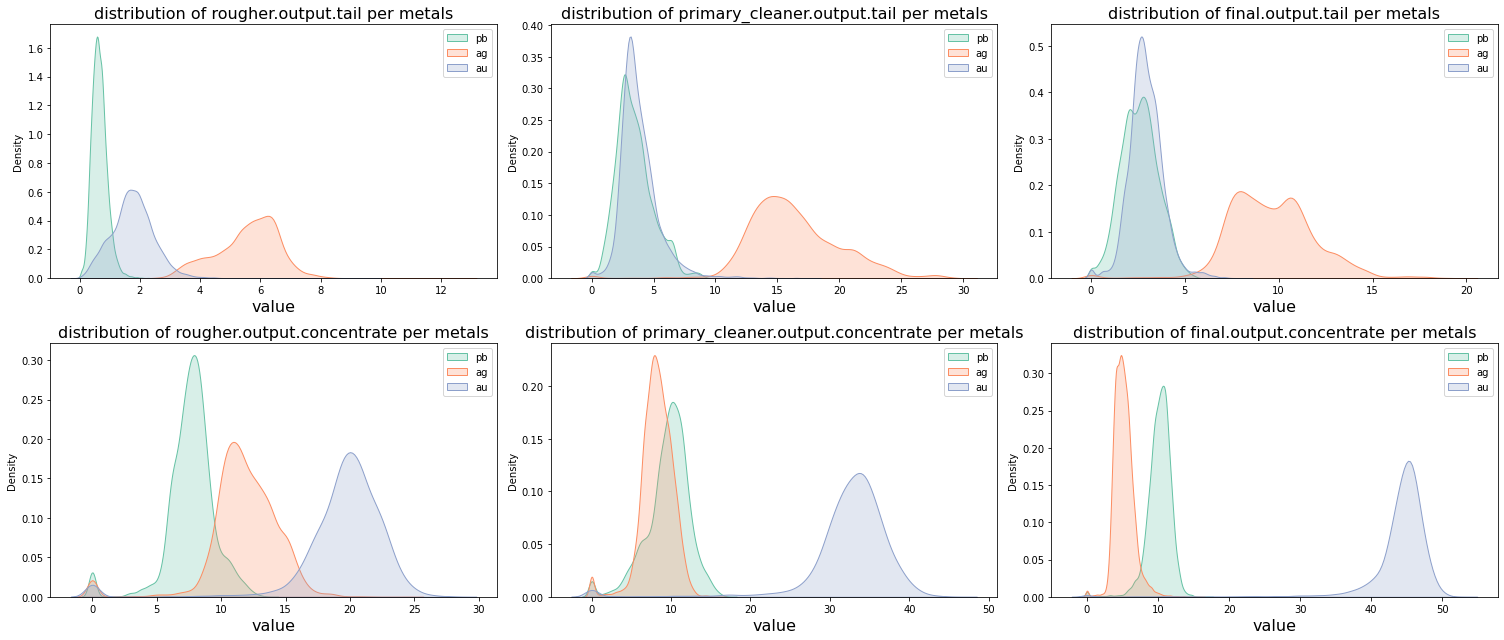

In [18]:
metals = ['au', 'ag', 'pb']
columns = ['rougher.output.tail', 'primary_cleaner.output.tail','final.output.tail',\
           'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

_, axs = plt.subplots(2,3, figsize=(21, 9))
axs = axs.flatten()

for column, ax in zip(columns, axs):
    cols = [f"{t}_{m}" for t,m in zip([column]*3,metals)]
    temp_df = pd.melt(df_train[cols])
    temp_df["variable"] = temp_df["variable"].str.replace(column+"_","")
    display_group_density_plot(temp_df, groupby="variable", on="value", title=f"distribution of {column} per metals", ax=ax)
    ax.legend()

plt.tight_layout()
plt.show()

We can see that there are some abnormal values of the concentration, especially in rougher and primary_cleaner stages.

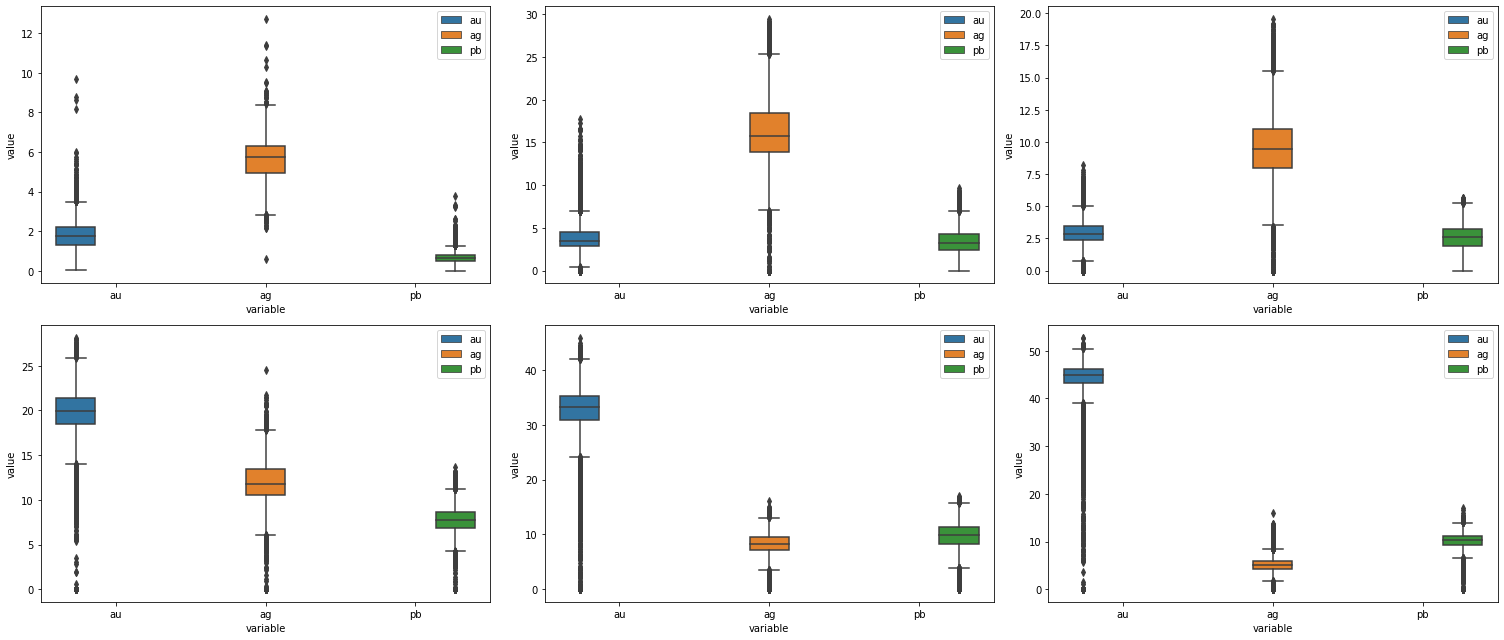

In [19]:
metals = ['au', 'ag', 'pb']
columns = ['rougher.output.tail', 'primary_cleaner.output.tail','final.output.tail',\
           'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

_, axs = plt.subplots(2,3, figsize=(21, 9))
axs = axs.flatten()

for column, ax in zip(columns, axs):
    cols = [f"{t}_{m}" for t,m in zip([column]*3,metals)]
    temp_df = pd.melt(df_train[cols])
    temp_df["variable"] = temp_df["variable"].str.replace(column+"_","")
    sns.boxplot(x="variable", y="value", hue="variable", data=temp_df, ax=ax)
    ax.legend()

plt.tight_layout()
plt.show()

No handles with labels found to put in legend.


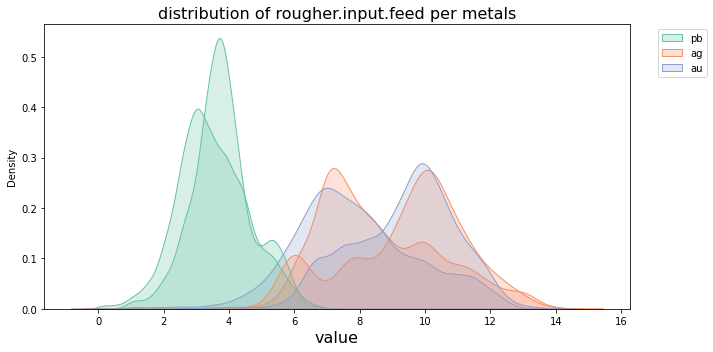

In [20]:
metals = ['au', 'ag', 'pb']
column = 'rougher.input.feed'
cols = [f"{t}_{m}" for t,m in zip([column]*3,metals)]
temp_df = pd.melt(df_train[cols])
temp_df["variable"] = temp_df["variable"].str.replace(column+"_","")
ax = display_group_density_plot(temp_df, groupby="variable", on="value", title=f"distribution of {column} per metals")
temp_df = pd.melt(df_test[cols])
temp_df["variable"] = temp_df["variable"].str.replace(column+"_","")
display_group_density_plot(temp_df, groupby="variable", on="value", title=f"distribution of {column} per metals", ax=ax)
plt.tight_layout()
plt.show()

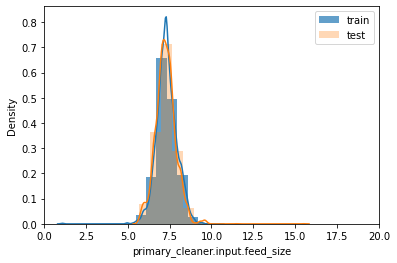

In [21]:
sns.distplot(df_train["primary_cleaner.input.feed_size"],bins=15, hist_kws=dict(alpha=0.7), label="train")
g = sns.distplot(df_test["primary_cleaner.input.feed_size"],bins=15, hist_kws=dict(alpha=0.3), label="test")
g.set(xlim=(0, 20))
g.legend()

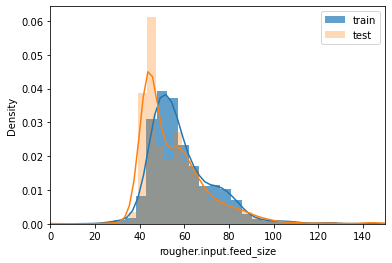

In [22]:
sns.distplot(df_train["rougher.input.feed_size"],bins=100, hist_kws=dict(alpha=0.7), label="train")
g = sns.distplot(df_test["rougher.input.feed_size"],bins=100, hist_kws=dict(alpha=0.3), label="test")
g.set(xlim=(0, 150))
g.legend()

In [23]:
display(df_train.describe()['rougher.input.feed_size'])

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [24]:
display(df_test.describe()['rougher.input.feed_size'])

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

#### Summary
According to density plots the feed particle size distributions in the training set and in the test set is different, but it's not very significant, also we can see that mean values are really close to each other.

The concentration of the gold was increased, but lead and silver after final stage were decreased or quite the same (gold's concentration is increasing in a linear way. it's seems there is some chemistry property of the lead, it's not changing so much in the final stage and silver's concetration is decreasing to a final stage)

In [48]:
metal_list = ['au', 'ag', 'pb']    

In [49]:
def metal_concen_sum(df, stage):
    total_concen = df[stage+metal_list[0]] + df[stage+metal_list[1]] + df[stage+metal_list[2]]
    return total_concen

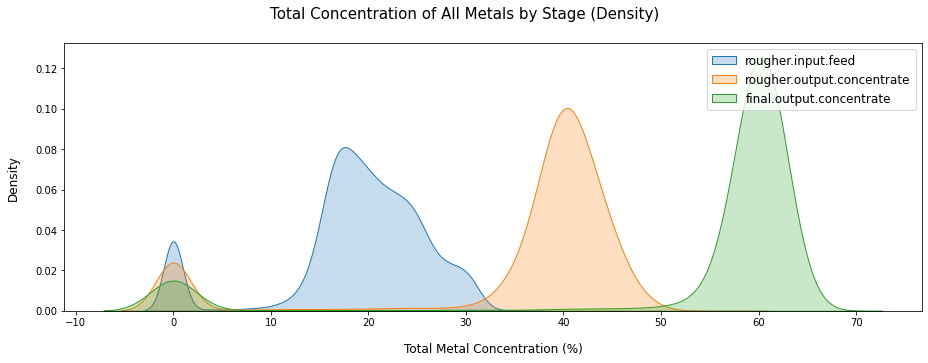

In [64]:
#Create plot to visualize total concentration of all metals at certain stages.
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Total Concentration of All Metals by Stage (Density)', fontsize=15, y=1)

sns.kdeplot(metal_concen_sum(df_full, 'rougher.input.feed_'), label='rougher.input.feed', fill=True)
sns.kdeplot(metal_concen_sum(df_full, 'rougher.output.concentrate_'), label='rougher.output.concentrate', fill=True)
sns.kdeplot(metal_concen_sum(df_full, 'final.output.concentrate_'), label='final.output.concentrate', fill=True)
plt.legend(fontsize=12)
plt.xlabel('Total Metal Concentration (%)', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.tight_layout()
plt.show()

#### Summary

As we can see from the graph, each metal seems to be bimodal with each with a very small peak at 0% metal concentration and then peaking again at a higher percentage. The small peak at 0% seems to be anomolies possibly from preprocess, but since they are so small, they are unlikely to make a material difference moving forward.

### Step 3 Build the model
 - Write a function to calculate the final sMAPE value.
 - Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

In [52]:
target = ['rougher.output.recovery', 'final.output.recovery']
features = list(set(df_train.columns).intersection(set(df_test.columns)).difference(set(target)))
state = np.random.RandomState(1357)

In [53]:
def smape(y_true, y_pred):
    frac = np.divide(np.abs(y_true - y_pred), (np.abs(y_true)+np.abs(y_pred))/2)
    return np.average(frac, axis=0)

In [54]:
def smape_final(y_true, y_pred):
    smape_out_rougher = smape(y_true[:, 0], y_pred[:, 0])
    smape_out_final = smape(y_true[:, 1], y_pred[:, 1])
    return 0.25*smape_out_rougher + 0.75*smape_out_final

In [55]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [56]:
smape_score = make_scorer(smape_final, greater_is_better=False)

In [57]:
X_train, X_test = df_train[features].values, df_test[features].values
y_train, y_test = df_train[target].values, df_test[target].values

In [58]:
lr = LinearRegression().fit(X_train, y_train)
scores_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring=smape_score)
display(("mean smape:", abs(scores_lr.mean())))
display(scores_lr)

('mean smape:', 0.12384596104847023)

array([-0.14402642, -0.09993082, -0.12746867, -0.11501761, -0.13278628])

In [59]:
params = {'min_samples_split': range(2, 10, 2), 'max_depth': range(4,8,2)}
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=state),param_grid=params,scoring=smape_score, cv=5, refit=True)
g_cv.fit(X_train, y_train)
best_params = g_cv.best_params_

In [65]:
dtr = DecisionTreeRegressor(**best_params).fit(X_train, y_train)
scores_dtr = cross_val_score(dtr, X_train, y_train, cv=5, scoring=smape_score)
display("mean smape:", abs(scores_dtr.mean()))
display(scores_dtr)

'mean smape:'

nan

array([-0.10244262, -0.09101664, -0.1265742 ,         nan, -0.10616876])

In [66]:
params = {'min_samples_split': range(2, 6, 2)}
rf_cv = GridSearchCV(RandomForestRegressor(random_state=state),param_grid=params,scoring=smape_score, cv=5, refit=True)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_

In [67]:
rfr = RandomForestRegressor(**best_params).fit(X_train, y_train)
scores_rfr = cross_val_score(rfr, X_train, y_train, cv=5, scoring=smape_score)
display("mean smape:", abs(scores_rfr.mean()))
display(scores_rfr)

'mean smape:'

0.11765130868060054

array([-0.10421895, -0.12522184, -0.11213923, -0.1244817 , -0.12219483])

In [70]:
# evalutating the best model on the test sets

In [93]:
y_pred=best_model.predict(X_test)
score = rfr.score(X_test, y_test)
display(abs(score))
final_rfr_smape = smape_final(y_test, y_pred)
display(final_rfr_smape)

0.0661874548329876

0.10467404379257109

Evaluation the best model we can see that the RandomForestRegressor has a final smape score of 0.1047 with an accuracy of 66%.

In [82]:
dm = DummyRegressor(strategy='mean').fit(X_train, y_train)
y_pred = dm.predict(X_test)
print('smape:', smape_final(y_test, y_pred))

smape: 0.10289630376021036


#### Summary:
We compared several models with Dummy Regressor (sMAPE=0.1029):

 - Linear regression: 0.1238

 - Decision tree regressor: nan

 - Random forest regressor: 0.1177 with a 0.1047 score on the test set with 66% accuracy.

It seems that the Dummy Regressor has the best result according to the sMAPE